# Fruits-360 dataset

A base de dados aqui utilizada já vem padronizada e tratada, portanto seguimos com o pré-processamento a ser realizado abaixo.

## Carregamento e Vizualização

In [22]:
import os
import numpy as np
import cv2
from PIL import Image
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix
import seaborn as sns
from scipy.stats import f_oneway
from skimage.feature import graycomatrix, graycoprops, hog
import matplotlib.pyplot as plt
import pickle
from collections import Counter

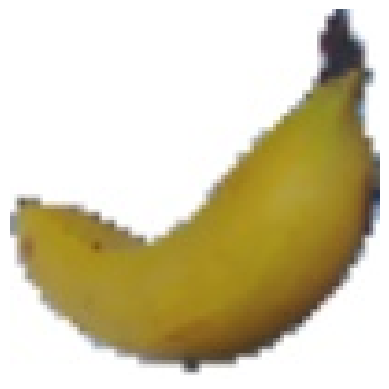

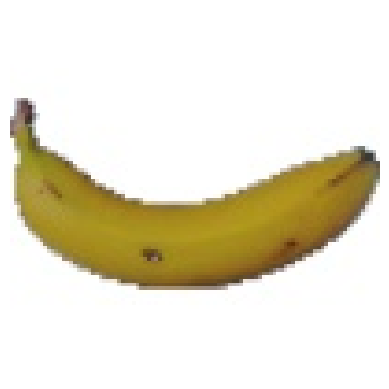

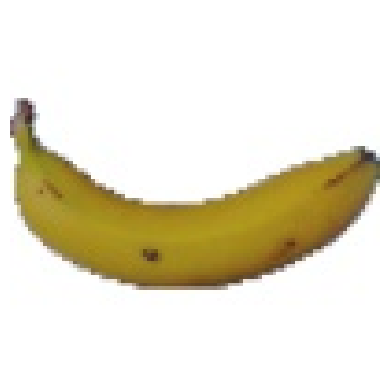

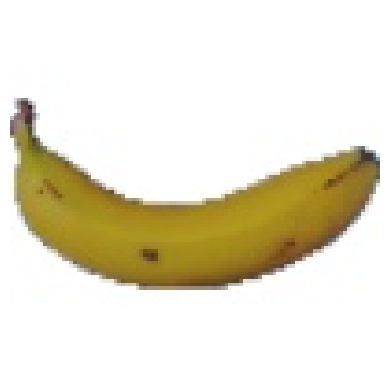

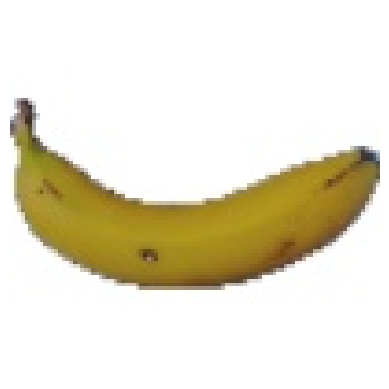

In [23]:
dataset_path = "fruits_dataset/fruits-test"

def visualize_samples(path, num_samples=5):
    sample_path = os.path.join(path, "Banana 1")
    sample_images = os.listdir(sample_path)[:num_samples]
    for img in sample_images:
        image = Image.open(os.path.join(sample_path, img))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

visualize_samples(dataset_path)

## Extração de Características

In [24]:
def extract_color_histogram(img):
    hist = np.histogram(img.ravel(), bins=256, range=(0, 256))[0]
    return hist

def extract_texture_features(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return features

def extract_hog_features(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True)
    return features

## Pré-processamento das Imagens

In [ ]:
FEATURE_SIZE = 200

def normalize_image(img):
    return img.astype(np.float32) / 255.0

def process_image(img_file, fruit_dir):
    img = cv2.imread(img_file)
    if img is None:
        print(f"Erro ao carregar imagem: {img_file}")
        return np.zeros(FEATURE_SIZE), fruit_dir
    img = normalize_image(img)

    # Extração de características
    color_hist = extract_color_histogram(img)
    texture_features = extract_texture_features(img.astype(np.uint8))
    hog_features = extract_hog_features(img.astype(np.uint8))

    # Concatenar todas as características
    all_features = np.concatenate([color_hist, texture_features, hog_features])

    # Padronizar tamanho do vetor de características
    if all_features.shape[0] < FEATURE_SIZE:
        all_features = np.pad(all_features, (0, FEATURE_SIZE - all_features.shape[0]))
    elif all_features.shape[0] > FEATURE_SIZE:
        all_features = all_features[:FEATURE_SIZE]  # Trunca caso seja maior

    return all_features, fruit_dir

# Carregar dados em lotes
def load_data_in_batches_with_joblib(dataset_path, batch_size=1000):
    fruit_dirs = os.listdir(dataset_path)
    for fruit_dir in fruit_dirs:
        fruit_path = os.path.join(dataset_path, fruit_dir)
        img_files = os.listdir(fruit_path)

        # Processar os arquivos de imagem em batches
        for i in range(0, len(img_files), batch_size):
            batch_files = img_files[i:i + batch_size]
            results = Parallel(n_jobs=-1, backend="threading")(  # Processamento paralelo no batch
                delayed(process_image)(os.path.join(fruit_path, img_file), fruit_dir)
                for img_file in batch_files
            )
            # Filtrar imagens com erro
            results = [r for r in results if r is not None]
            if results:  # Evitar lotes vazios
                features_batch, labels_batch = zip(*results)
                yield np.array(features_batch, dtype=np.float32), np.array(labels_batch)

# Inicializar scaler, PCA e LabelEncoder
scaler = StandardScaler()
# pca = PCA(n_components=0.95)
label_encoder = LabelEncoder()

# Obter todas as classes antes do processamento
all_labels = [label for _, labels in load_data_in_batches_with_joblib(dataset_path) for label in labels]
label_encoder.fit(all_labels)

X_train, X_test, y_train, y_test = [], [], [], []

# Processar dados em batches
for features_batch, labels_batch in load_data_in_batches_with_joblib(dataset_path, batch_size=1000):
    # Normalizar e transformar cada lote
    features_batch = scaler.fit_transform(features_batch)
    
    # PCA não utilizado, pois a base de dados está a mais pura e organizada possível
    # features_pca_batch = pca.fit_transform(features_batch)

    # Transformação dos rótulos usando LabelEncoder
    labels_batch = label_encoder.transform(labels_batch)

    # Divisão em treino e teste com estratificação
    X_train_batch, X_test_batch, y_train_batch, y_test_batch = train_test_split(
        features_batch, labels_batch, test_size=0.2, random_state=42, stratify=labels_batch
    )

    # Armazenar batches
    X_train.append(X_train_batch)
    X_test.append(X_test_batch)
    y_train.append(y_train_batch)
    y_test.append(y_test_batch)

# Concatenar todos os batches processados
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)

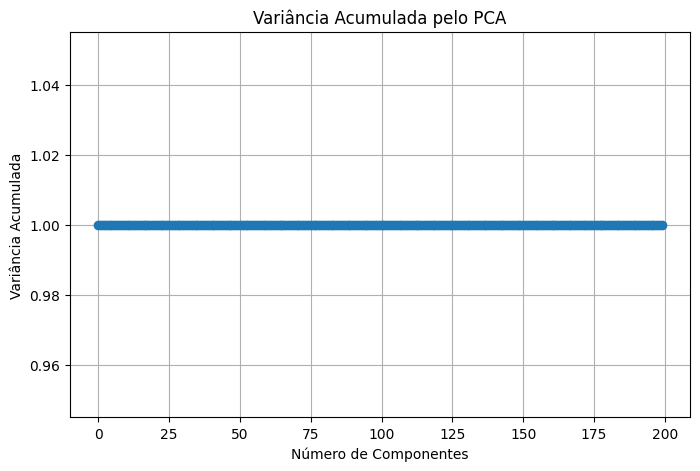

In [26]:
pca = PCA()
X_pca = pca.fit_transform(X_train)

# Plotando a variância acumulada
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.title('Variância Acumulada pelo PCA')
plt.grid(True)
plt.show()

## Classificação de Padrões

Distribuição de Classes: Counter({5: 984})


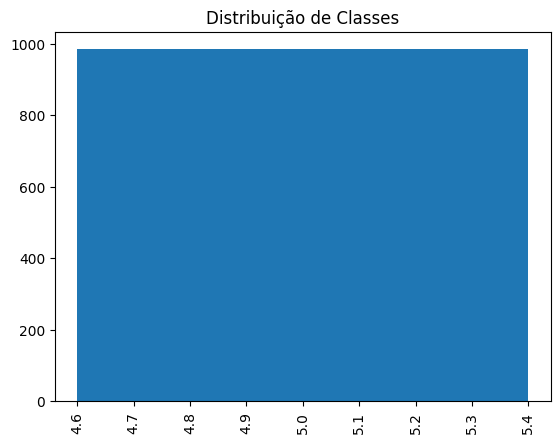

In [27]:
from collections import Counter
class_distribution = Counter(labels_batch)
print("Distribuição de Classes:", class_distribution)
sorted_classes = sorted(class_distribution.keys())
plt.bar(sorted_classes, [class_distribution[c] for c in sorted_classes])
plt.xticks(rotation=90)
plt.title("Distribuição de Classes")
plt.show()

In [28]:
# Classificação usando SVM
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_svm = grid_search.best_estimator_
svm_predictions = best_svm.predict(X_test)

# Classificação usando KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)

# Classificação usando Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

## Regressão de Funções e Avaliação

In [29]:
# Avaliação do SVM
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

# Validação cruzada com SVM
svm_cv_scores = cross_val_score(best_svm, X_train, y_train, cv=5)
print("SVM Cross-validation Accuracy:", svm_cv_scores.mean())

# Avaliação do KNN
print("\nKNN Classification Report:")
print(classification_report(y_test, knn_predictions))
print("KNN Accuracy:", accuracy_score(y_test, knn_predictions))

# Validação cruzada com KNN
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print("KNN Cross-validation Accuracy:", knn_cv_scores.mean())

# Avaliação do Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_predictions))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))

# Validação cruzada com Random Forest
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
print("Random Forest Cross-validation Accuracy:", rf_cv_scores.mean())

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.02      0.04       132
           1       0.33      0.14      0.20       132
           2       0.29      0.64      0.40       120
           3       0.24      0.24      0.24       188
           4       0.34      0.24      0.28       132
           5       0.33      0.47      0.39       197

    accuracy                           0.30       901
   macro avg       0.30      0.29      0.26       901
weighted avg       0.30      0.30      0.26       901

SVM Accuracy: 0.2974472807991121
SVM Cross-validation Accuracy: 0.3058278264045097

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.22      0.19       132
           1       0.24      0.31      0.27       132
           2       0.20      0.22      0.21       120
           3       0.25      0.27      0.26       188
           4       0.23      0.14      0.18     

In [30]:
# Análise de variância se scores seguem uma distribuição normal e têm variâncias similares (ANOVA)
f_stat, p_value = f_oneway(svm_cv_scores, knn_cv_scores, rf_cv_scores)
print("ANOVA F-Statistic:", f_stat)
print("ANOVA P-Value:", p_value)

if p_value < 0.05:
    print("Rejeitamos a hipótese nula: há diferenças estatisticamente significativas entre os modelos.")
else:
    print("Não rejeitamos a hipótese nula: não há evidências de diferenças significativas entre os modelos.")

# Análise de variância para valores se scores não seguem uma distribuição normal (Kruskal-Wallis)
from scipy.stats import kruskal

h_stat, p_value = kruskal(svm_cv_scores, knn_cv_scores, rf_cv_scores)
print("Kruskal-Wallis H-Statistic:", h_stat)
print("Kruskal-Wallis P-Value:", p_value)

if p_value < 0.05:
    print("Rejeitamos a hipótese nula: há diferenças estatisticamente significativas entre os modelos.")
else:
    print("Não rejeitamos a hipótese nula: não há evidências de diferenças significativas entre os modelos.")

ANOVA F-Statistic: 16.333771942663915
ANOVA P-Value: 0.0003759542854731998
Rejeitamos a hipótese nula: há diferenças estatisticamente significativas entre os modelos.
Kruskal-Wallis H-Statistic: 9.997853309481213
Kruskal-Wallis P-Value: 0.006745183025237461
Rejeitamos a hipótese nula: há diferenças estatisticamente significativas entre os modelos.


In [31]:
print("SVM Train Accuracy:", best_svm.score(X_train, y_train))
print("SVM Test Accuracy:", accuracy_score(y_test, svm_predictions))

print("KNN Train Accuracy:", knn.score(X_train, y_train))
print("KNN Test Accuracy:", accuracy_score(y_test, knn_predictions))

print("Random Forest Train Accuracy:", rf.score(X_train, y_train))
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_predictions))

SVM Train Accuracy: 0.3150264845274603
SVM Test Accuracy: 0.2974472807991121
KNN Train Accuracy: 0.48731530526902705
KNN Test Accuracy: 0.22308546059933407
Random Forest Train Accuracy: 0.9994424310008364
Random Forest Test Accuracy: 0.23640399556048836


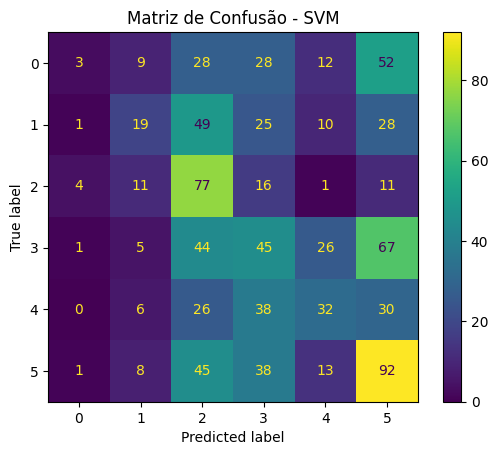

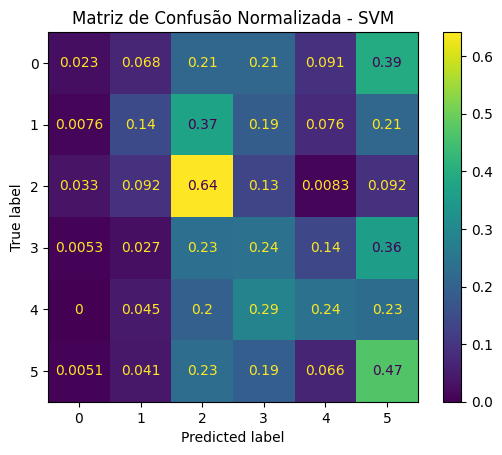

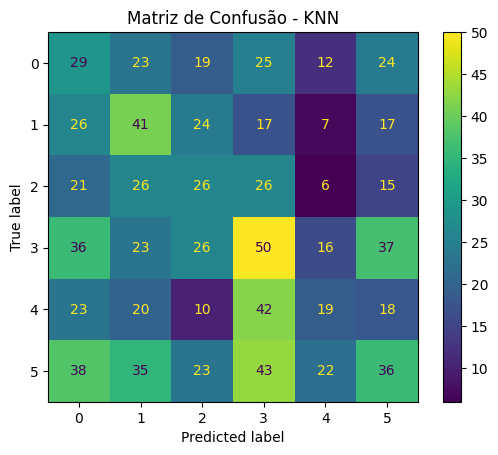

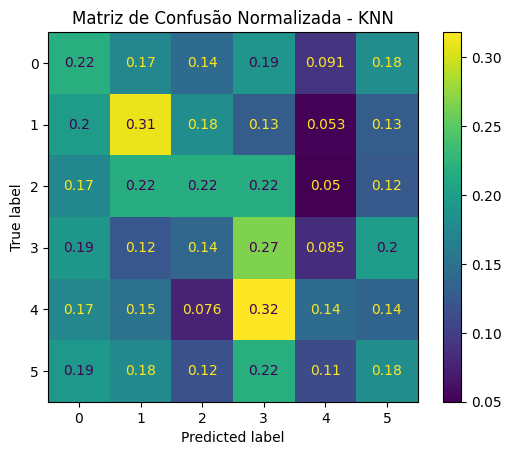

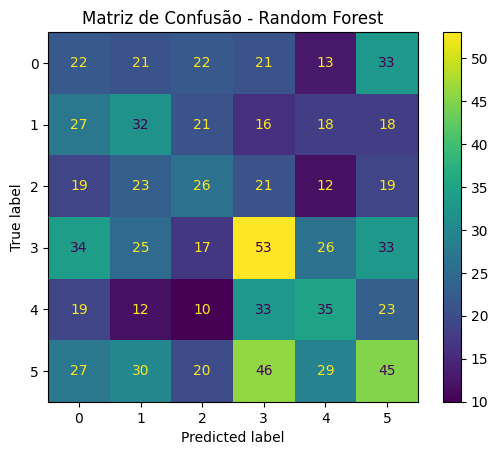

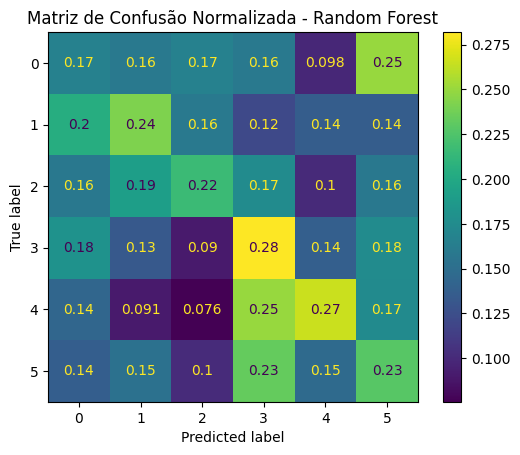

In [32]:
ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test)
plt.title("Matriz de Confusão - SVM")
plt.show()

ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, normalize='true')
plt.title("Matriz de Confusão Normalizada - SVM")
plt.show()

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.title("Matriz de Confusão - KNN")
plt.show()

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize='true')
plt.title("Matriz de Confusão Normalizada - KNN")
plt.show()

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Matriz de Confusão - Random Forest")
plt.show()

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, normalize='true')
plt.title("Matriz de Confusão Normalizada - Random Forest")
plt.show()

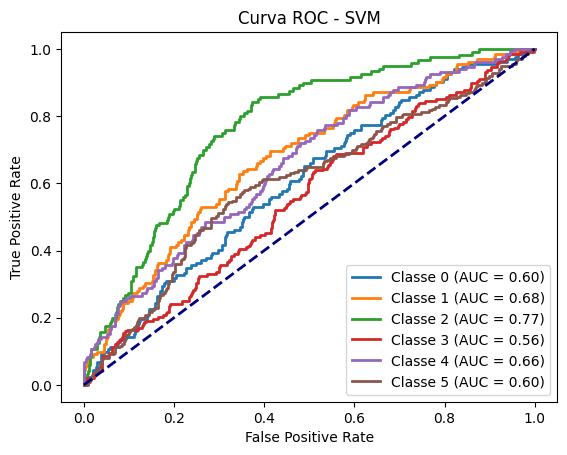

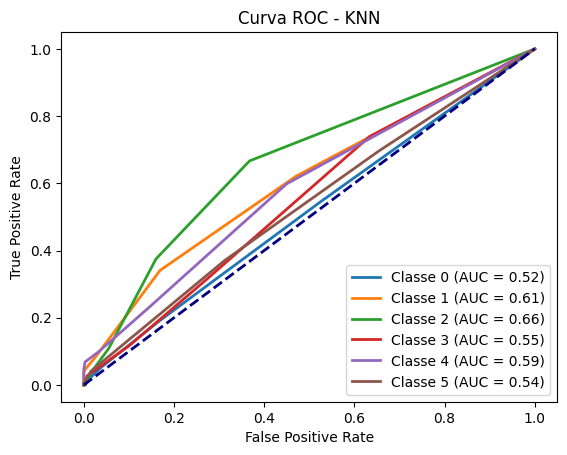

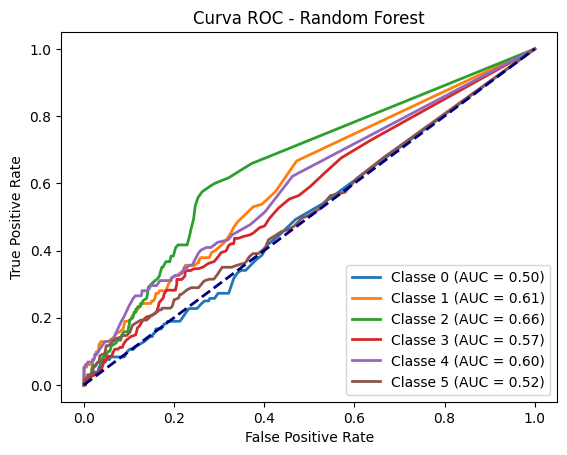

In [33]:
# Função para plotar a curva ROC para cada classe
def plot_multiclass_roc(y_test_bin, y_score, model_name):
    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha de referência
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Binarizar rótulos (One-hot encoding)
n_classes = len(np.unique(y_test))  # Número de classes únicas
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))  # Torna (901,) -> (901, n_classes)

# Probabilidades preditas pelos modelos
y_score_svm = best_svm.decision_function(X_test)  # Saída do SVM
y_score_knn = knn.predict_proba(X_test)  # KNN já retorna probabilidades
y_score_rf = rf.predict_proba(X_test)  # Random Forest também retorna probabilidades

# Plotar curvas ROC para cada modelo
plot_multiclass_roc(y_test_bin, y_score_svm, "SVM")
plot_multiclass_roc(y_test_bin, y_score_knn, "KNN")
plot_multiclass_roc(y_test_bin, y_score_rf, "Random Forest")

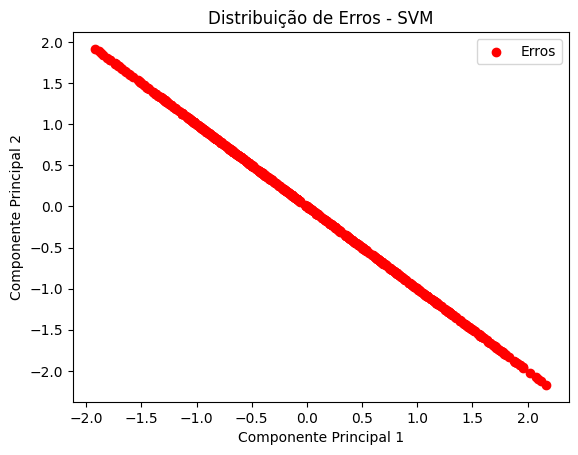

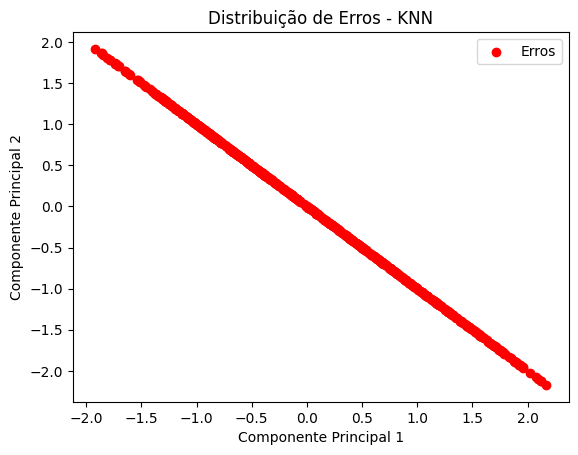

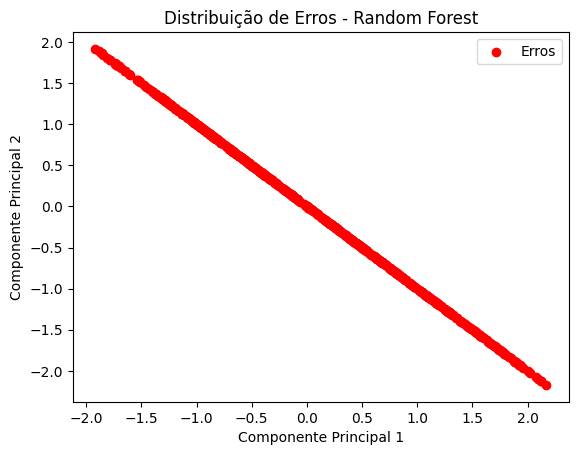

In [34]:
def plot_error_2d(errors, title):
    plt.scatter(errors[:, 0], errors[:, 1], color='red', label='Erros')
    plt.title(title)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.show()

# Encontrar amostras mal classificadas corretamente
errors_svm = X_test[np.where(y_test != svm_predictions)]
errors_knn = X_test[np.where(y_test != knn_predictions)]
errors_rf = X_test[np.where(y_test != rf_predictions)]

# Plotar os erros para cada modelo
plot_error_2d(errors_svm, "Distribuição de Erros - SVM")
plot_error_2d(errors_knn, "Distribuição de Erros - KNN")
plot_error_2d(errors_rf, "Distribuição de Erros - Random Forest")

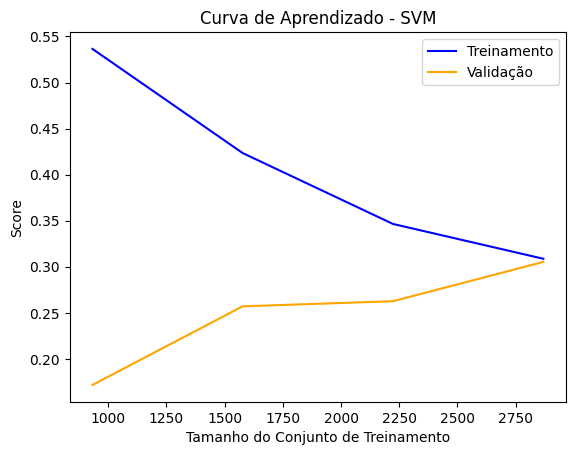

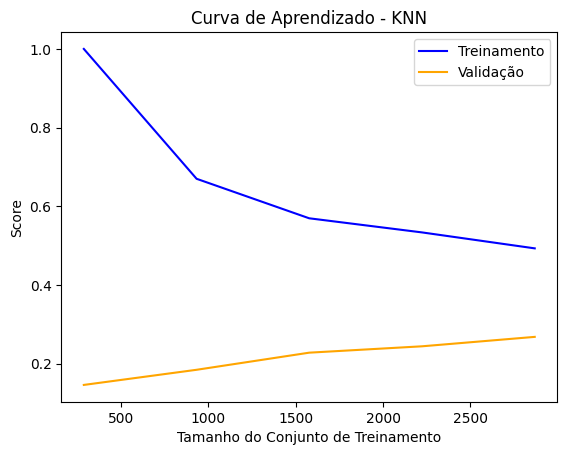

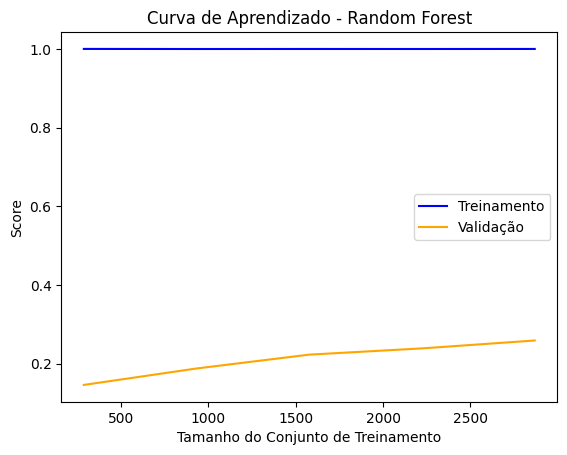

In [35]:
def plot_learning_curve(train_sizes, train_mean, test_mean, title):
    plt.plot(train_sizes, train_mean, label='Treinamento', color='blue')
    plt.plot(train_sizes, test_mean, label='Validação', color='orange')
    plt.xlabel('Tamanho do Conjunto de Treinamento')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(best_svm, X_train, y_train, cv=5)
train_mean_svm = train_scores_svm.mean(axis=1)
test_mean_svm = test_scores_svm.mean(axis=1)
plot_learning_curve(train_sizes_svm, train_mean_svm, test_mean_svm, "Curva de Aprendizado - SVM")

train_sizes_knn, train_scores_knn, test_scores_knn = learning_curve(knn, X_train, y_train, cv=5)
train_mean_knn = train_scores_knn.mean(axis=1)
test_mean_knn = test_scores_knn.mean(axis=1)
plot_learning_curve(train_sizes_knn, train_mean_knn, test_mean_knn, "Curva de Aprendizado - KNN")

train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(rf, X_train, y_train, cv=5)
train_mean_rf = train_scores_rf.mean(axis=1)
test_mean_rf = test_scores_rf.mean(axis=1)
plot_learning_curve(train_sizes_rf, train_mean_rf, test_mean_rf, "Curva de Aprendizado - Random Forest")

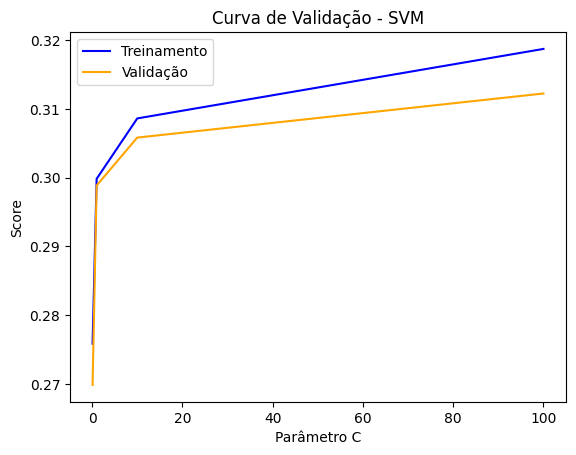

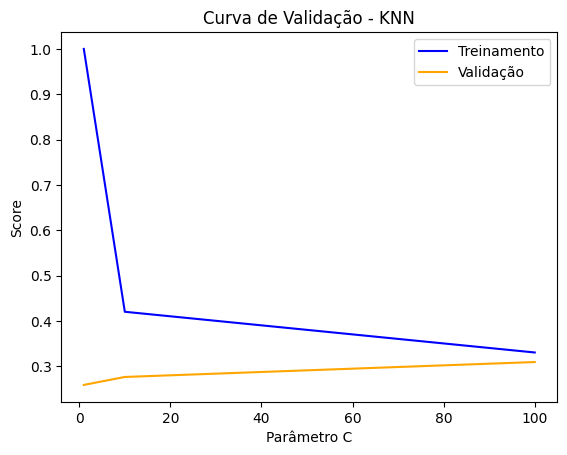

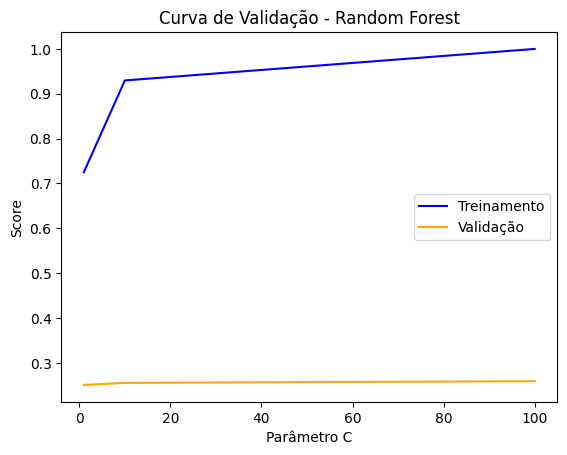

In [36]:
def plot_validation_curve(param_range, train_mean, test_mean, title):
    plt.plot(param_range, train_mean, label='Treinamento', color='blue')
    plt.plot(param_range, test_mean, label='Validação', color='orange')
    plt.xlabel('Parâmetro C')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

param_range = [0.1, 1, 10, 100]

train_scores_vc_svm, test_scores_vc_svm = validation_curve(SVC(), X_train, y_train, param_name="C", param_range=param_range, cv=5)
train_mean_vc_svm = train_scores_vc_svm.mean(axis=1)
test_mean_vc_svm = test_scores_vc_svm.mean(axis=1)
plot_validation_curve(param_range, train_mean_vc_svm, test_mean_vc_svm, "Curva de Validação - SVM")

train_scores_vc_knn, test_scores_vc_knn = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors", param_range=param_range, cv=5)
train_mean_vc_knn = train_scores_vc_knn.mean(axis=1)
test_mean_vc_knn = test_scores_vc_knn.mean(axis=1)
plot_validation_curve(param_range, train_mean_vc_knn, test_mean_vc_knn, "Curva de Validação - KNN")

train_scores_vc_rf, test_scores_vc_rf = validation_curve(RandomForestClassifier(), X_train, y_train, param_name="n_estimators", param_range=param_range, cv=5)
train_mean_vc_rf = train_scores_vc_rf.mean(axis=1)
test_mean_vc_rf = test_scores_vc_rf.mean(axis=1)
plot_validation_curve(param_range, train_mean_vc_rf, test_mean_vc_rf, "Curva de Validação - Random Forest")

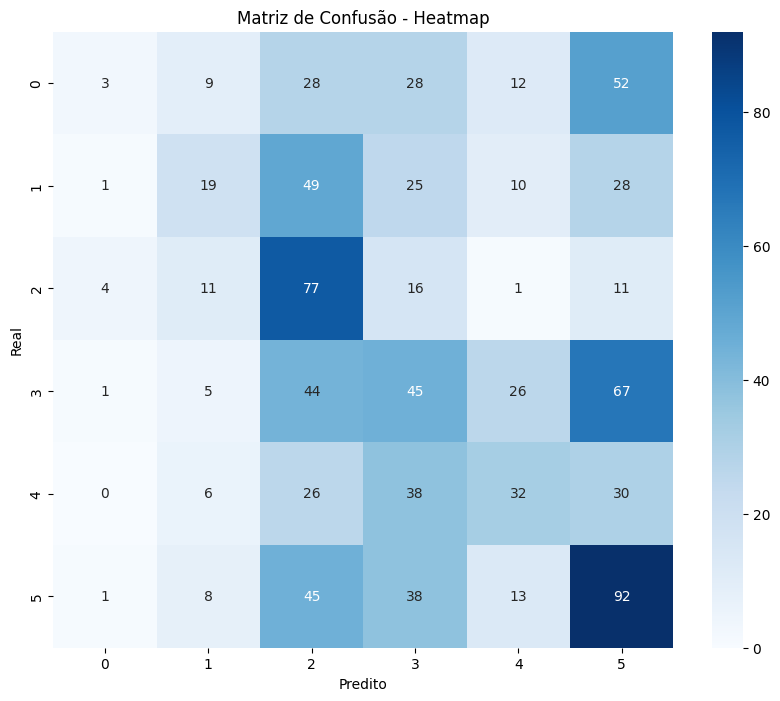

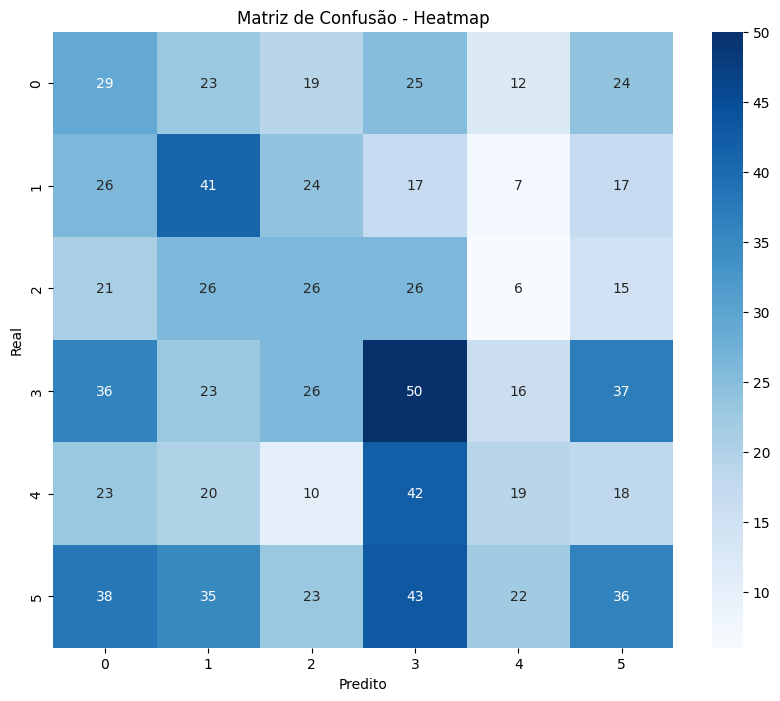

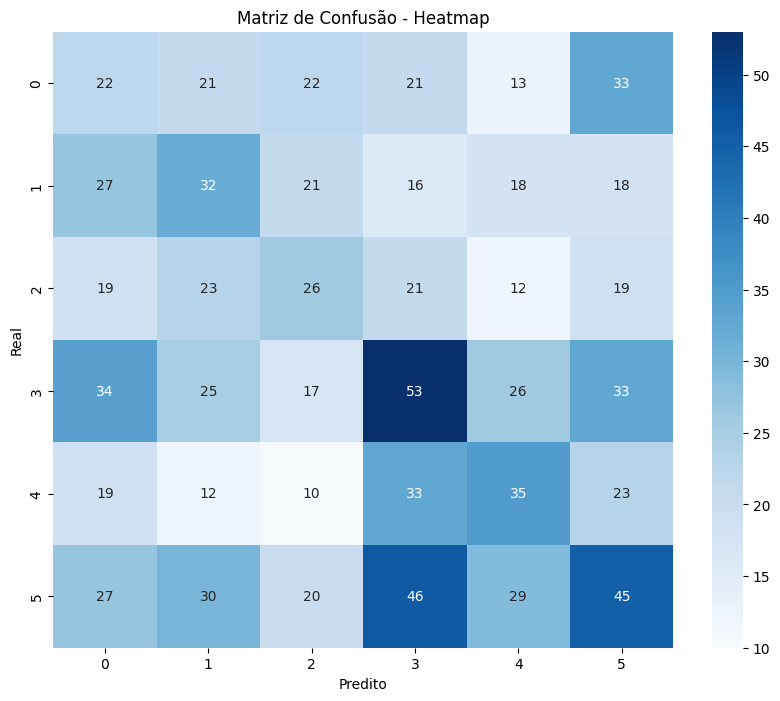

In [37]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusão - Heatmap")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

cm_svm = confusion_matrix(y_test, svm_predictions)
cm_knn = confusion_matrix(y_test, knn_predictions)
cm_rf = confusion_matrix(y_test, rf_predictions)

plot_confusion_matrix(cm_svm)
plot_confusion_matrix(cm_knn)
plot_confusion_matrix(cm_rf)

## Salvando os Resultados

In [38]:
# Salva características para uso posterior
with open("features.pkl", "wb") as f:
    pickle.dump((features_batch, labels_batch), f)